In [2]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.
[ OK ] xgboost version 1.5.1 is installed.
[ OK ] shap version 0.40.0 is installed.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import linear_model
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import KFold, train_test_split
from datetime import datetime, date
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

In [4]:
df = pd.read_csv("../data/spotify_prediction_updated_data.csv")
df = df.drop(['Unnamed: 0'], axis=1)
index = df[df['time_signature']==0].index
df.drop(index , inplace=True)

index2 = df[df['release_date'] == '0000'].index
df.drop(index2 , inplace=True)

years = []
for date in df['release_date']:
    years.append(int(date[:4]))
    
df['year'] = years
## Add day, month - see if it affects the models 
df['duration_min'] = df['duration_ms']/60000
df['explicit_flag'] = np.where(df['explicit']==True, 1, 0)

df['recency'] = abs(2022-df['year'])

In [5]:
df.shape

(18551, 29)

In [6]:
df.isnull().any().any()

False

In [7]:
# release_date_datetime_lst, new_dates, days  = [], [], []

# for str_date in df['release_date']:
#     release_date_datetime_lst = parser.parse(str_date, default=datetime(2021,1,1))
# df['release_date_timestamp'] = release_date_datetime_lst

# for date in df['release_date_datetime']:
#     new_dates.append(date.to_pydatetime()) 
    
# df['release_date_datetime'] = new_dates

# for date in df['release_date_datetime']:
#     days.append(abs((date-date.today()).days))
# df['recency_of_track'] = days

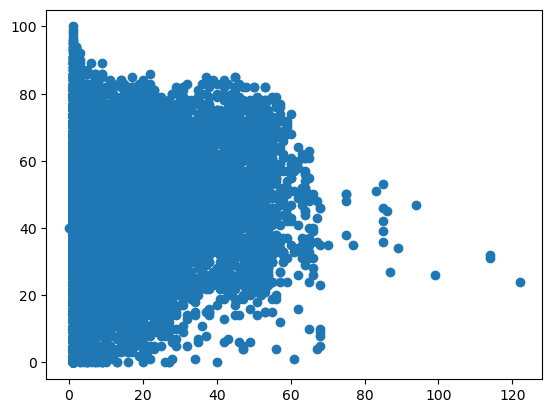

In [8]:
plt.scatter(df['recency'], df['Popularity'])

<AxesSubplot:>

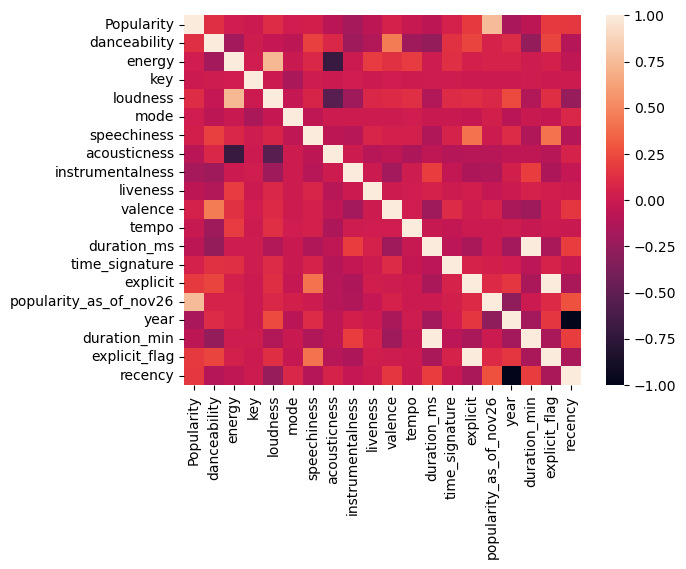

In [9]:
sns.heatmap(df.corr())

In [10]:
X = df.drop(['Popularity', 'release_date', 'year', 'duration_ms', 'explicit', 'Artist_Name', 'Genres',
                                    'Track_Name', 
                                    'Playlist', 
                                    'id',
                                    'uri', 
                                    'track_href',
                                    'analysis_url',
                                    'popularity_as_of_nov26'],axis=1)
y = df['Popularity']
X.shape, y.shape

((18551, 15), (18551,))

In [11]:
df[['danceability','energy',  'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence', 'tempo']].describe()

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,18551.000000,18551.000000,18551.000000,18551.000000,18551.000000,18551.000000,18551.000000,18551.000000
mean,0.550703,0.685432,0.086670,0.209838,0.120321,0.199024,0.486355,123.251179
std,0.169134,0.218937,0.090627,0.279467,0.257914,0.159612,0.237153,29.592012
min,0.059900,0.000020,0.022500,0.000000,0.000000,0.011900,0.000000,42.956000
25%,0.436000,0.537000,0.035600,0.003100,0.000001,0.097600,0.301000,99.953000
50%,0.551000,0.716000,0.050300,0.061100,0.000313,0.132000,0.481000,120.996000
75%,0.670000,0.872000,0.092500,0.339000,0.042400,0.265000,0.669000,142.191500
max,0.989000,1.000000,0.960000,0.996000,0.996000,0.992000,0.986000,249.438000


In [12]:
from sklearn.compose import ColumnTransformer as ct
from sklearn.preprocessing import OneHotEncoder as ohe, StandardScaler as ss, MinMaxScaler as mm

oh_vars = ['time_signature', 'key']
ss_vars = ['loudness', 'tempo', 'duration_min','danceability','energy', \
           'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence']
oh_encoder = ohe(sparse=False, handle_unknown = 'ignore') 
ss_encoder = ss()

preprocessor = ct(transformers = [('cat', oh_encoder, oh_vars),
                               ('ss_cont', ss_encoder, ss_vars),
                               ('drop_cols', 'drop', 
          ['loudness', 'tempo', 'time_signature', 
           'key', 'loudness', 'tempo', 'duration_min','danceability','energy', 
           'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence'])],
                                    remainder='passthrough', sparse_threshold=0) 

In [13]:
df_check = pd.DataFrame(data = preprocessor.fit_transform(X), columns = preprocessor.get_feature_names_out())
df_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18551 entries, 0 to 18550
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cat__time_signature_1      18551 non-null  float64
 1   cat__time_signature_3      18551 non-null  float64
 2   cat__time_signature_4      18551 non-null  float64
 3   cat__time_signature_5      18551 non-null  float64
 4   cat__key_0                 18551 non-null  float64
 5   cat__key_1                 18551 non-null  float64
 6   cat__key_2                 18551 non-null  float64
 7   cat__key_3                 18551 non-null  float64
 8   cat__key_4                 18551 non-null  float64
 9   cat__key_5                 18551 non-null  float64
 10  cat__key_6                 18551 non-null  float64
 11  cat__key_7                 18551 non-null  float64
 12  cat__key_8                 18551 non-null  float64
 13  cat__key_9                 18551 non-null  flo

# Testing Out 5 Models

In [36]:
def MLpipe_KFold_RMSE(X, y, preprocessor, algo, param_grid):
    
    initial_random_state = 42
    best_scores, best_params, baseline_scores, final_models = [], [], [], []
    rmse = make_scorer(r2_score, greater_is_better=True)
    
    for i in range(10):
        
        # Split the data into train, test and validation sets
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, \
                                           shuffle=True, random_state=initial_random_state*i)
        y_test_mean = np.full((len(y_test),1), y_test.mean(), dtype=int)
        kf = KFold(n_splits=4, shuffle = True, random_state=initial_random_state*i)

        # Pre-processing 
        pipe = make_pipeline(preprocessor, algo)

        # Grid Search CV
        grid = GridSearchCV(pipe, param_grid, cv = kf, scoring=rmse, verbose=True, n_jobs=-1)
        grid.fit(X_other, y_other)
        final_models.append(grid.best_estimator_.get_params())
        best_params.append(grid.best_params_)
        baseline_scores.append(r2_score(y_test, y_test_mean))
        best_scores.append(abs(grid.score(X_test, y_test)))

    best_results_df = pd.DataFrame({'Best_params':best_params, 'Best_scores':best_scores, \
                                    'Baseline':baseline_scores, 'Models':final_models}) 
    return best_results_df

In [13]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')


params = {'params_Ridge' : {'ridge__solver':['sag','saga'],
                            'ridge__alpha':[1,0.1,0.01,0.001,0.0001,100],
                            'ridge__fit_intercept':[True, False]},
          
          'params_RF':{'randomforestregressor__n_estimators': [100, 150, 200, 250, 300],
                       'randomforestregressor__max_depth': [3,5,7,11], 
                       'randomforestregressor__max_features':['sqrt', 'log2', None]},
          
          'params_SVR':{'svr__gamma': [1e-3, 1e-2, 1e-1, 1e1, 1e3, 1e5],
                        'svr__C': [1e-3, 1e-2,1e-1, 1e0, 1e1,1e2, 1e3]},
          
          'params_KNNR':{'kneighborsregressor__n_neighbors': [1,3,5,10,50], 
                         'kneighborsregressor__weights':['uniform', 'distance']},
          
          'params_XGBR':{"xgbregressor__learning_rate": [0.01], 
                         "xgbregressor__max_depth": [1,5,10,30,50]}
         }

models = {'L2':Ridge(),
          'RandomForest':RandomForestRegressor(),
          'SVR':SVR(),
          'KNN_Regression':KNeighborsRegressor(),
          'XGBRegressor':XGBRegressor()
         }

all_dfs = []
for (which_model, model, params) in zip(models.keys(), models.values(), params.values()):
    result_df = MLpipe_KFold_RMSE(X, y, preprocessor, model, params)
    result_df['Model'] = which_model 
    all_dfs.append(result_df)

final_output_df = pd.concat(all_dfs) 

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds fo

/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits


In [18]:
final_output_df['diff'] = final_output_df['Baseline']-final_output_df['Best_scores']
final_output_df['Better than Baseline?'] = np.where(final_output_df['diff']<0, "Yes", "No")
final_output_df

,Best_params,Best_scores,Baseline,Model,diff,Better than Baseline?
0,"{'ridge__alpha': 100, 'ridge__fit_intercept': ...",0.127672,-0.000460,L2,-0.128132,Yes
1,"{'ridge__alpha': 0.001, 'ridge__fit_intercept'...",0.131768,-0.000313,L2,-0.132081,Yes
2,"{'ridge__alpha': 0.01, 'ridge__fit_intercept':...",0.127821,-0.000393,L2,-0.128214,Yes
3,"{'ridge__alpha': 100, 'ridge__fit_intercept': ...",0.142821,-0.000315,L2,-0.143137,Yes
4,"{'ridge__alpha': 0.01, 'ridge__fit_intercept':...",0.153164,-0.000425,L2,-0.153589,Yes
5,"{'ridge__alpha': 100, 'ridge__fit_intercept': ...",0.121553,-0.001011,L2,-0.122564,Yes
6,"{'ridge__alpha': 0.001, 'ridge__fit_intercept'...",0.142077,-0.001083,L2,-0.143159,Yes
7,"{'ridge__alpha': 0.001, 'ridge__fit_intercept'...",0.128162,-0.000030,L2,-0.128192,Yes
8,"{'ridge__alpha': 0.001, 'ridge__fit_intercept'...",0.139693,-0.000600,L2,-0.140293,Yes
9,"{'ridge__alpha': 1, 'ridge__fit_intercept': Tr...",0.125526,-0.000726,L2,-0.126252,Yes


In [15]:
means, stds = [], []
for model in final_output_df['Model'].unique():
    sub_df = final_output_df[final_output_df['Model']==model]
    means.append(sub_df['Best_scores'].mean())
    stds.append(np.std(sub_df['Best_scores'])) 

mean_and_std_output = pd.DataFrame({'Model':final_output_df['Model'].unique(), \
                                    'Mean':means,
                                    'Std_Dev':stds})

mean_and_std_output.sort_values(by="Mean", ascending=True) 

,Model,Mean,Std_Dev
0,L2,0.134026,0.009417
3,KNN_Regression,0.154498,0.009736
2,SVR,0.182018,0.008004
1,RandomForest,0.196425,0.008853
4,XGBRegressor,0.670977,0.017240


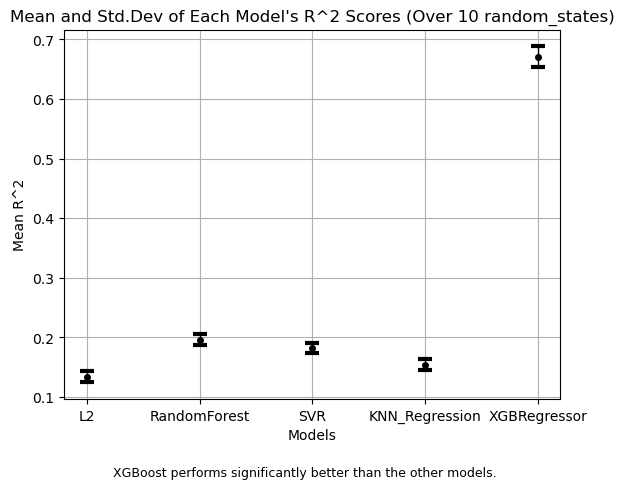

In [22]:
# plot_results = plot_df.iloc[:-2]
plt.errorbar(mean_and_std_output['Model'], mean_and_std_output['Mean'], yerr=mean_and_std_output['Std_Dev'], \
             fmt='o', color='Black', elinewidth=1,capthick=3,errorevery=1, alpha=1, ms=4, capsize = 5)
plt.title("Mean and Std.Dev of Each Model's R^2 Scores (Over 10 random_states)")
plt.xlabel("Models")
plt.ylabel("Mean R^2")
txt="XGBoost performs significantly better than the other models."
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.grid()
plt.savefig('error_bar_of_models.png', format='png', dpi=300)
plt.show()

In [19]:
final_output_df.to_csv("all_5_models_output.csv")

# Random Forest

In [37]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')


params = {'params_RF':{'randomforestregressor__n_estimators': [100, 150, 200, 250, 300],
                       'randomforestregressor__max_depth': [3,5,7,11], 
                       'randomforestregressor__max_features':['sqrt', 'log2', None]},
         }

models = {'RandomForest':RandomForestRegressor()}

all_dfs = []
for (which_model, model, params) in zip(models.keys(), models.values(), params.values()):
    result_df = MLpipe_KFold_RMSE(X, y, preprocessor, model, params)
    result_df['Model'] = which_model 
    all_dfs.append(result_df)

final_output_df = pd.concat(all_dfs) 

Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits


In [70]:
for i in range(10):
    print(final_output_df['Models'][i]['randomforestregressor'])

RandomForestRegressor(max_depth=11, max_features=None, n_estimators=150)
RandomForestRegressor(max_depth=11, max_features=None, n_estimators=250)
RandomForestRegressor(max_depth=11, max_features=None, n_estimators=300)
RandomForestRegressor(max_depth=11, max_features=None, n_estimators=150)
RandomForestRegressor(max_depth=11, max_features=None, n_estimators=300)
RandomForestRegressor(max_depth=11, max_features=None, n_estimators=250)
RandomForestRegressor(max_depth=11, max_features=None, n_estimators=250)
RandomForestRegressor(max_depth=11, max_features=None, n_estimators=300)
RandomForestRegressor(max_depth=11, max_features=None, n_estimators=300)
RandomForestRegressor(max_depth=11, max_features=None, n_estimators=300)


In [75]:
import joblib
fnames = ['rf_regressor_random_state01.pkl',
         'rf_regressor_random_state02.pkl',
         'rf_regressor_random_state03.pkl',
         'rf_regressor_random_state04.pkl',
         'rf_regressor_random_state05.pkl',
         'rf_regressor_random_state06.pkl',
         'rf_regressor_random_state07.pkl',
         'rf_regressor_random_state08.pkl',
         'rf_regressor_random_state09.pkl',
         'rf_regressor_random_state10.pkl',]

# output the data
# this outputs the files using the index, i, + fnames
for i, filename in enumerate(fnames, 0):
    joblib.dump( final_output_df['Models'][i]['randomforestregressor'], filename)

In [80]:
final_output_df

,Best_params,Best_scores,Baseline,Models,Model
0,"{'randomforestregressor__max_depth': 11, 'rand...",0.187163,-0.000460,"{'memory': None, 'steps': [('columntransformer...",RandomForest
1,"{'randomforestregressor__max_depth': 11, 'rand...",0.184112,-0.000313,"{'memory': None, 'steps': [('columntransformer...",RandomForest
2,"{'randomforestregressor__max_depth': 11, 'rand...",0.187913,-0.000393,"{'memory': None, 'steps': [('columntransformer...",RandomForest
3,"{'randomforestregressor__max_depth': 11, 'rand...",0.191448,-0.000315,"{'memory': None, 'steps': [('columntransformer...",RandomForest
4,"{'randomforestregressor__max_depth': 11, 'rand...",0.214913,-0.000425,"{'memory': None, 'steps': [('columntransformer...",RandomForest
5,"{'randomforestregressor__max_depth': 11, 'rand...",0.194957,-0.001011,"{'memory': None, 'steps': [('columntransformer...",RandomForest
6,"{'randomforestregressor__max_depth': 11, 'rand...",0.202426,-0.001083,"{'memory': None, 'steps': [('columntransformer...",RandomForest
7,"{'randomforestregressor__max_depth': 11, 'rand...",0.196639,-0.000030,"{'memory': None, 'steps': [('columntransformer...",RandomForest
8,"{'randomforestregressor__max_depth': 11, 'rand...",0.209553,-0.000600,"{'memory': None, 'steps': [('columntransformer...",RandomForest
9,"{'randomforestregressor__max_depth': 11, 'rand...",0.192426,-0.000726,"{'memory': None, 'steps': [('columntransformer...",RandomForest


In [81]:
means, stds = [], []
for model in final_output_df['Model'].unique():
    sub_df = final_output_df[final_output_df['Model']==model]
    means.append(sub_df['Best_scores'].mean())
    stds.append(np.std(sub_df['Best_scores'])) 

mean_and_std_output = pd.DataFrame({'Model':final_output_df['Model'].unique(), \
                                    'Mean':means,
                                    'Std_Dev':stds})

mean_and_std_output.sort_values(by="Mean", ascending=True) 

,Model,Mean,Std_Dev
0,RandomForest,0.196155,0.009498
